# Data Challenge
### Salimatou Traore

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from evaluator import *
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import os


with open('data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

dat.keys(), {key: type(dat[key]) for key in dat.keys()}
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

## Exploration des données

In [24]:
# Afficher les dimensions des ensembles de données et les premiers éléments pour comprendre leur structure
Y_train_unique, S_train_unique = set(Y), set(S)
Y_train_distribution = {label: list(Y).count(label) for label in Y_train_unique}
S_train_distribution = {label: list(S).count(label) for label in S_train_unique}
print(f'Nombre de labels : {len(Y_train_unique)}')
print(f"Nombre d'attribut sensible : {len(S_train_unique)}")
print(f'Distribution des labels par classe {Y_train_distribution}')
print(f'Distribution des données par attribut sensible {S_train_distribution}')

Nombre de labels : 28
Nombre d'attribut sensible : 2
Distribution des labels par classe {0: 387, 1: 703, 2: 2273, 3: 184, 4: 206, 5: 386, 6: 994, 7: 262, 8: 107, 9: 499, 10: 93, 11: 1402, 12: 524, 13: 1316, 14: 542, 15: 136, 16: 178, 17: 97, 18: 1715, 19: 2918, 20: 504, 21: 8285, 22: 1295, 23: 92, 24: 467, 25: 948, 26: 1121, 27: 115}
Distribution des données par attribut sensible {0: 14956, 1: 12793}


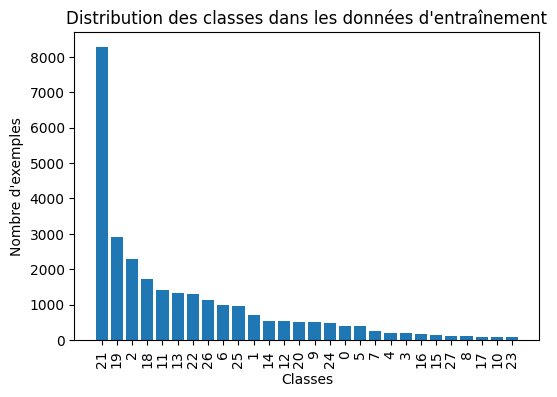

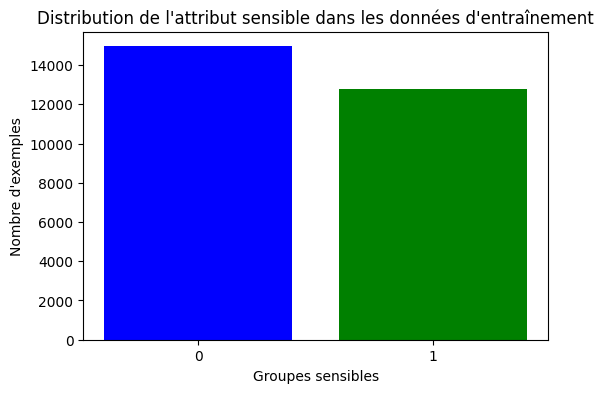

In [19]:
import matplotlib.pyplot as plt
import numpy as np

#Distribution des classes
labels = list(Y_train_distribution.keys())
counts = list(Y_train_distribution.values())
# Trier les classes par nombre d'exemples
sorted_indices = np.argsort(counts)[::-1]
sorted_labels = [labels[idx] for idx in sorted_indices]
sorted_counts = [counts[idx] for idx in sorted_indices]
plt.figure(figsize=(6, 4))
plt.bar(range(len(sorted_labels)), sorted_counts, tick_label=sorted_labels)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes dans les données d\'entraînement')
plt.xticks(rotation=90)
plt.show()

#Distribution de l'attribut sensible
labels = list(S_train_distribution.keys())
counts = list(S_train_distribution.values())
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, tick_label=labels, color=['blue', 'green'])
plt.xlabel('Groupes sensibles')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution de l\'attribut sensible dans les données d\'entraînement')
plt.xticks(labels)
plt.show()


### Distribution des Classes Cibles (Y)
- Il y a **28 classes uniques** (de 0 à 27)
- La distribution des classes varie considérablement, allant de **93 occurrences pour la classe 10** à **8285 occurrences pour la classe 21**. Cette large variance suggère un déséquilibre significatif entre les classes. Par exemple, la classe 21 est beaucoup plus représentée dans l'ensemble d'apprentissage que les autres classes, tandis que la classe 10 est l'une des moins représentées.

### Distribution des Attributs Sensibles (S)
- Il y a **2 attributs sensibles uniques** (0 et 1).
- La répartition entre ces deux groupes est un peu déséquilibrée, avec **14956 occurrences pour le groupe 0** et **12793 occurrences pour le groupe 1**.

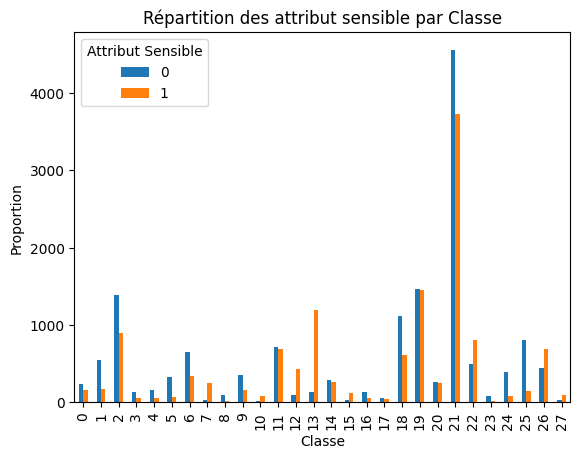

In [20]:
data = pd.DataFrame({'Class': Y, 'Gender': S})

# Répartition des genres par classe 
distribution_resampled = data.groupby('Class')['Gender'].value_counts(normalize=False).unstack(fill_value=0)

distribution_resampled.plot(kind='bar')
plt.title('Répartition des attribut sensible par classe')
plt.xlabel('Classe')
plt.ylabel('Proportion')
plt.legend(title='Attribut Sensible')
plt.show()

### Analyse
- La hauteur des barres indique que certaines classes sont plus peuplées que d'autres. Par exemple, la classe 21 a un grand nombre d'instances par rapport aux autres classes.
- Il y a une variabilité dans la répartition des genres par classe. Certaines classes, comme la classe 21, sont dominées par un seul genre, tandis que d'autres classes ont une distribution plus équilibrée entre les genres (exemple la classe 19)
- Certains genres sont sous-représentés dans plusieurs classes, ce qui pourrait indiquer un potentiel biais dans l'ensemble des données ou refléter une distribution naturelle dans la population de référence.

## Réequillibrage des classes grâce à la méthode resample

Un rééquilibrage des données est  effectué pour corriger les déséquilibres des classes par rapport à l'attribut sensible.

La méthode resample est utilisé car elle permet de rééquilibrer les classes en sous-échantillonnant (réduisant les instances de la classe majoritaire) ou en sur-échantillonnant (augmentant les instances de la classe minoritaire) de manière contrôlée. Cela crée un ensemble de données plus équilibré où chaque classe a un poids équivalent, permettant au modèle d’apprendre de manière plus uniforme sur toutes les classes.

In [21]:
from sklearn.utils import resample

X = pd.DataFrame(X)
Y = pd.Series(Y)
S = pd.Series(S)

dataframe = pd.concat([X, Y, S], axis=1)

#Pour chaque classe
for y in dataframe[dataframe.columns[-2]].unique():
    # Sous-groupes pour chaque valeur de S
    group_0 = dataframe[(dataframe[dataframe.columns[-2]] == y) & (dataframe[dataframe.columns[-1]] == 0)]
    group_1 = dataframe[(dataframe[dataframe.columns[-2]] == y) & (dataframe[dataframe.columns[-1]] == 1)]
    
    max_samples = max(len(group_0), len(group_1))
    
    # Sous-échantillonnez ou sur-échantillonnez
    group_0_resampled = resample(group_0, replace=len(group_0)<max_samples, n_samples=max_samples, random_state=42)
    group_1_resampled = resample(group_1, replace=len(group_1)<max_samples, n_samples=max_samples, random_state=42)
    
    dataframe_resampled = pd.concat([group_0_resampled, group_1_resampled])
    
    dataframe_resampled = dataframe_resampled.sample(frac=1, random_state=42)
    
    if y == dataframe[dataframe.columns[-2]].unique()[0]:
        dataframe_final = dataframe_resampled
    else:
        dataframe_final = pd.concat([dataframe_final, dataframe_resampled])

X_resampled = dataframe_final[dataframe.columns[:-2]]
Y_resampled = dataframe_final[dataframe.columns[-2]]
S_resampled = dataframe_final[dataframe.columns[-1]]

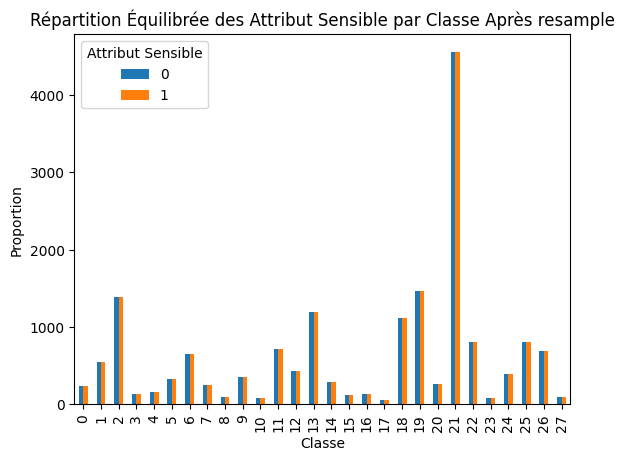

In [22]:
resampled_data = pd.DataFrame({'Class': Y_resampled, 'Attribut_Sensible': S_resampled})

distribution_resampled = resampled_data.groupby('Class')['Attribut_Sensible'].value_counts(normalize=False).unstack(fill_value=0)

distribution_resampled.plot(kind='bar')
plt.title('Répartition équilibrée des attribut sensible par classe après resample')
plt.xlabel('Classe')
plt.ylabel('Proportion')
plt.legend(title='Attribut Sensible')
plt.show()

Le graphique montre la répartition équilibrée des genres après l’application de resample.

Avant le rééquilibrage, il est possible que certaines classes avaient beaucoup plus d’exemples d’un genre que de l’autre, ce qui aurait pu entraîner un biais dans la prédiction de ces classes. Après rééquilibrage, on observe que chaque classe a maintenant une répartition égale des genres, ce qui indique que la méthode resample a réussi à normaliser la répartition entre les genres pour chaque classe.

Objecif : 
- Améliorer l’équité et la précision des prédictions pour toutes les classes

## Utilisation de la regression logistique pour la classification

Pour la classification, mon choix s'est porté sur la régression logistique car :

- C'est un modèle simple et efficace qui fournit des résultats robustes même avec des jeux de données relativement petits ou peu complexes.
- Elle permet d'obtenir des probabilités de classe, offrant ainsi une mesure de la confiance dans ses prédictions.
- Le modèle est interprétable; il est possible de comprendre l'importance de chaque caractéristique dans la prédiction.
- Elle peut être régularisée pour éviter le surajustement, en pénalisant les coefficients trop importants.

Lorsque j'ai abordé le réglage des hyperparamètres, j'ai initialement envisagé d'utiliser GridSearchCV pour une recherche exhaustive. Cependant, en raison de contraintes de temps et de la grande quantité de données, cette méthode s'est avérée trop coûteuse en termes de temps de calcul. J'ai donc adopté une approche manuelle, plus pratique et ciblée, me permettant d'ajuster les hyperparamètres de manière itérative.

Dans ce processus, j'ai constaté que les paramètres les plus cruciaux à optimiser étaient le paramètre de régularisation 'C' et le type d'algorithme utilisé pour l'optimisation, désigné par le paramètre 'solver'. En expérimentant différentes valeurs, j'ai découvert que 'lbfgs', un algorithme d'optimisation basé sur l'approximation de la méthode de Newton, fournissait de manière cohérente de meilleurs résultats pour notre modèle spécifique. 

Quant au paramètre 'C', qui contrôle la force de la régularisation dans la régression logistique (des valeurs plus petites spécifient une régularisation plus forte), un réglage fin au millième près s'est avéré nécessaire pour équilibrer précisément la variance et le biais. 

Enfin, j'ai décidé de fixer 'max_iter' à 20 000 itérations. Cette valeur élevée garantit que le processus d'optimisation a suffisamment de temps pour converger vers la meilleure solution possible, évitant ainsi des problèmes de convergence qui pourraient biaiser nos résultats. Cela s'est avéré particulièrement important en raison des réglages précis de 'C' et du 'solver', qui peuvent affecter le temps nécessaire à l'algorithme pour trouver le minimum global de la fonction de coût.

In [16]:
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X_resampled, Y_resampled, S_resampled, test_size=0.3, random_state=42, stratify = Y_resampled)

clf = LogisticRegression(C=0.7656, solver='lbfgs', random_state=42, max_iter=20000).fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)

0.7472264184362662


In [ ]:
# Load the "true" test data
X_test = dat['X_test']
S_test = dat['S_test']

# Classify the provided test data with you classifier
y_test = clf.predict(X_test)
results=pd.DataFrame(y_test, columns= ['score'])

results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)
# np.savetxt('y_test_challenge_student.txt', y_test, delimiter=',')

# Retour sur expérience 

1. Une expérimentation avec K-Means clustering avant la régression logistique avait été testé et avait pour but d'introduire une dimension supplémentaire de segmentation dans les données, espérant ainsi améliorer la précision de la classification. Cependant, cette approche n'a pas abouti à une amélioration significative des performances, ce qui pourrait s'expliquer par un surajustement.

2. Avant de prendre conscience de l'importance du déséquilibre des classes, j'ai également exploré des modèles tels que les SVM (Support Vector Machines), les RNN (Réseaux de Neurones Récurrents) et les MLP (Multi-layer Perceptrons). Ces méthodes, bien que puissantes, n'ont pas donné les résultats escomptés sans un préalable rééquilibrage des classes.
Après avoir rééquilibré les classes, il est plausible que ces modèles puissent montrer des améliorations en termes de performances.

3. En plus de la régression logistique, l'utilisation de techniques de bagging aurait pu être envisagée. Le bagging, consiste à entraîner plusieurs modèles sur des sous-ensembles des données, puis à agréger leurs prédictions. Cette méthode peut améliorer la stabilité et l'exactitude des prédictions, réduire la variance et contrôler le surajustement. 

Par manque de temps, je n'ai pas eu l'opportunité de tester ces dernières méthodes après le rééquilibrage des classes, ce qui aurait pu potentiellement améliorer encore davantage les résultats.